In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import xgboost as xgb 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

#https://www.datacamp.com/community/tutorials/xgboost-in-python 
#tutorial above to help create the model 

In [2]:
def get_datasets(std_size=False):
    # My python only likes absolute paths 
    brca = pd.read_csv('/Users/danielraad/Desktop/data/Gistic2_CopyNumber_BRCA', sep='\t')
    ovca = pd.read_csv('/Users/danielraad/Desktop/data/Gistic2_CopyNumber_OVCA', sep='\t')
    brca.set_index('Gene Symbol', inplace=True)
    ovca.set_index('Gene Symbol', inplace=True)
    brca = brca.transpose()
    ovca = ovca.transpose()
    brca['BRCA'] = 1
    ovca['BRCA'] = 0
    print('size brca, ovca', len(brca), len(ovca))
    if not std_size:
        print('normal size', len(brca)+len(ovca))
        df = pd.concat([brca, ovca[1:]])
    elif std_size:
        print('sampled size', len(ovca)+len(ovca))
        df = pd.concat([brca[0:len(ovca)], ovca[1:]])
    return df
df = get_datasets()

size brca, ovca 1080 579
normal size 1659


/Users/danielraad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [3]:
#seperate the target variable from the other variables
from sklearn.model_selection import train_test_split
X = df.drop(['BRCA'], axis = 1)
y = df['BRCA']
X_train, X_test, y_train, y_tests = train_test_split(X, y, test_size = 0.33)
y_red = pd.Series(y)
features = list(X_train.columns)

In [4]:
import hyperopt as hp 
from hyperopt import Trials,fmin,STATUS_OK


### Step 1 : defining the objective function
def objective(params, n_folds=3):

# Converting pandas dataframe into xgboost format
    d_train = xgb.DMatrix(data=X, label=y)  

# Running cross validation on your xgboost model
    cv_results = xgb.cv(params, d_train, nfold = n_folds, num_boost_round = 500, 
                        early_stopping_rounds = 25, metrics = 'rmse', seed = 0)
  
# returns the loss on validation set
    loss = min(cv_results['test-rmse-mean'])
    return loss


### step 2 : defining the search space
xgb_space = {
#    max_depth : maximum depth allowed for every tree
# hp.choice.choice will select 1 value from the given list
    'max_depth':hp.hp.choice('max_depth', np.arange(6, 14,1, dtype=int)),
#    subsample : maximum allowed rows for every tree
    'subsample':hp.hp.quniform('subsample',0.5,1.0,0.05),
#    colsample_bytree : maximum allowed features for every tree
# hp.hp.quniform returns a float between a given range
    'colsample_bytree':hp.hp.quniform('colsample_bytree',0.5,1.0,0.05),
#    min_child-weight : minimum number of instances required in each node
    'min_child_weight':hp.hp.quniform('min_child_weight', 100, 1000,100),
#    reg_alpha : L1 regularisation term on weights
    'reg_alpha': hp.hp.uniform('reg_alpha', 0.0, 1.0),
#    reg_lambda : L2 regularisation term on weights
    'reg_lambda': hp.hp.uniform('reg_lambda', 0.0, 1.0)}
    
    
### step 3 : storing the results of every iteration    
bayes_trials = Trials()
MAX_EVALS = 20

# Optimize
best = fmin(fn = objective, space = xgb_space, algo = hp.tpe.suggest, 
max_evals = MAX_EVALS, trials = bayes_trials)

### best will the return the the best hyperparameter set

100%|██████████| 20/20 [16:50<00:00, 35.20s/trial, best loss: 0.227029]           


In [5]:
print(best)

{'colsample_bytree': 0.55, 'max_depth': 2, 'min_child_weight': 100.0, 'reg_alpha': 0.07675346261208471, 'reg_lambda': 0.8148727138018221, 'subsample': 0.9}


In [6]:
#Creating the Classification model, running 
xg_class = xgb.XGBClassifier(colsample_bytree = 0.55, max_depth = 2, min_child_weight = 100, reg_alpha = 0.07675346261208471, reg_lambda = 0.8148727138018221, subsample = 0.9  )
xg_class.fit(X_train,y_train)

train_xg_predictions = xg_class.predict(X_train)
train_xg_probs       = xg_class.predict_proba(X_train)[:, 1]

xg_predictions = xg_class.predict(X_test)
xg_probs       = xg_class.predict_proba(X_test)[:, 1]

In [7]:
from sklearn.model_selection import cross_val_score
y_red = pd.Series(y)
scores = cross_val_score(xg_class,df,y_red,cv=10,scoring='accuracy')
print(scores.mean())

0.9860825118656443


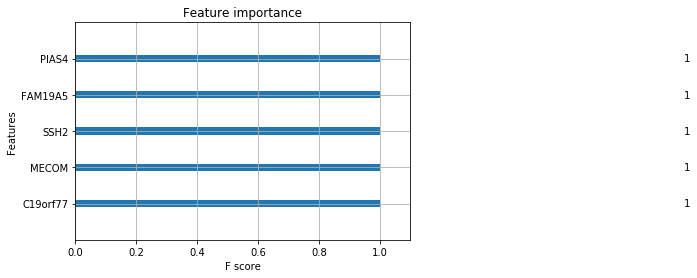

In [9]:
from xgboost import plot_importance
plot_importance(xg_class)
plt.show()

In [10]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[150  49]
 [ 16 333]]


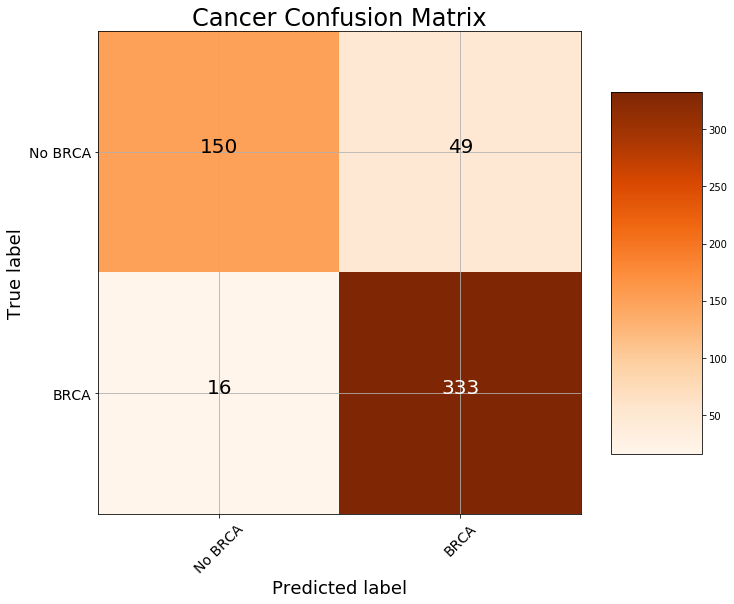

In [11]:
cm = confusion_matrix(y_tests, xg_predictions)
plot_confusion_matrix(cm, classes = ['No BRCA', 'BRCA'],
                      title = 'Cancer Confusion Matrix')

In [12]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_tests, [1 for _ in range(len(y_tests))])
    baseline['precision'] = precision_score(y_tests, [1 for _ in range(len(y_tests))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_tests, predictions)
    results['precision'] = precision_score(y_tests, predictions)
    results['roc'] = roc_auc_score(y_tests, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_tests, [1 for _ in range(len(y_tests))])
    model_fpr, model_tpr, _ = roc_curve(y_tests, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

Recall Baseline: 1.0 Test: 0.95 Train: 0.93
Precision Baseline: 0.64 Test: 0.87 Train: 0.88
Roc Baseline: 0.5 Test: 0.94 Train: 0.93


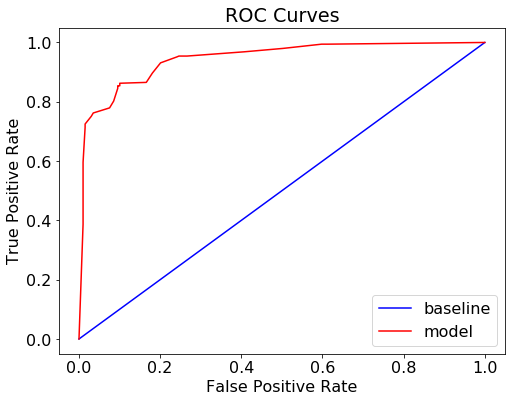

In [13]:
evaluate_model(xg_predictions, xg_probs, train_xg_predictions, train_xg_probs)

In [14]:
accuracy = accuracy_score(y_tests, xg_predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 88.14%
